# Task 2: Setup

In [18]:
!pip install -q pydub

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

print(tf.__version__)
print(tfds.__version__)

2.5.0
4.0.1


In [20]:
dataset = tfds.load("gtzan_music_speech")

# Task 3: Explore the Data

In [21]:
dataset

{'train': <PrefetchDataset shapes: {audio: (None,), audio/filename: (), label: ()}, types: {audio: tf.int64, audio/filename: tf.string, label: tf.int64}>}

In [22]:
train = dataset["train"]

data_iter = iter(train)

In [23]:
example=next(data_iter)

In [24]:
example

{'audio': <tf.Tensor: shape=(661500,), dtype=int64, numpy=array([-2821, -3743, -4288, ...,  -717,   132,  1548])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'vlobos.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

In [25]:
audio=example.get('audio')
label=example.get('label')

print(label)

Audio(audio, rate=22050)

tf.Tensor(0, shape=(), dtype=int64)


In [26]:
index_to_class = {0: "music", 1: "speech"}
class_to_index = {"music": 0, "speech": 1}

In [27]:
def plot_waveform(audio):
    plt.plot(audio)
    plt.xlabel("samples")
    plt.ylabel("amplitude")
    plt.show()

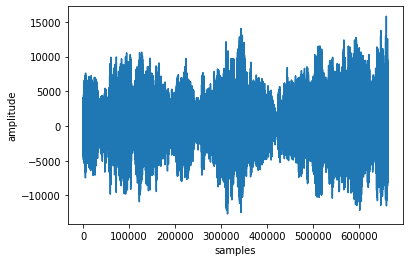

In [28]:
plot_waveform(audio)

# Task 4: Spectrogram

In [29]:
def get_stft(audio, frame_length=2048, frame_step=512, fft_length=256):
    return tf.signal.stft(
        tf.cast(audio, tf.float32),
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

In [30]:
audio_stft=get_stft(audio)
audio_spec=tf.abs(audio_stft)

In [31]:
def plot_spec(spec):
    plt.figure(figsize=(12, 4))
    plt.imshow(tf.transpose(spec), cmap="viridis")
    plt.colorbar()
    plt.show()

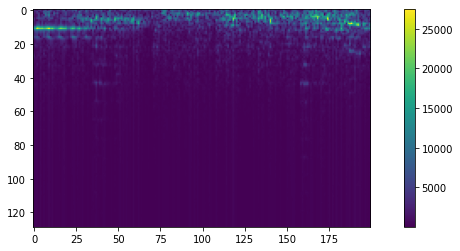

In [32]:
plot_spec(audio_spec[:200])

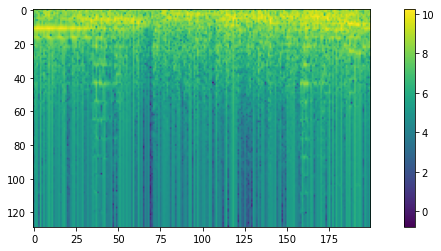

In [33]:
audio_spec_log=tf.math.log(audio_spec)
plot_spec(audio_spec_log[:200])

In [34]:
def get_spectrogram(audio):
    audio_stft = get_stft(audio)
    audio_spec = tf.abs(audio_stft)
    return tf.math.log(tf.transpose(audio_spec))

# Task 5: Prepare the Data

In [36]:
sr = 22050 # samples per second
chunk_len = 5 # seconds

def preprocess_example(example):
  audio=example.get('audio')
  label=example.get('label')

  x_batch, y_batch =None , None

  for i in range(0,6):
    start_sample=i*chunk_len * sr
    end_sample= (i+1)*chunk_len*sr
    audio_chunk=audio[start_sample:end_sample]
    audio_spec=get_spectrogram(audio_chunk)
    audio_spec=tf.expand_dims(audio_spec,axis=0)
    current_label=tf.expand_dims(label,axis=0)

    x_batch=audio_spec if x_batch is None else tf.concat([x_batch,audio_spec],axis=0)
    y_batch=current_label if y_batch is None else tf.concat([y_batch,current_label],axis=0)

  return x_batch,y_batch


In [37]:
x_train , y_train =None,None

for example in tqdm(iter(train)):
  x_batch,y_batch=preprocess_example(example)

  x_train=x_batch if x_train is None else tf.concat([x_train,x_batch],axis=0)
  y_train=y_batch if y_train is None else tf.concat([y_train,y_batch],axis=0)

128it [00:04, 27.35it/s]


In [38]:
print(x_train.shape,y_train.shape)

(768, 129, 212) (768,)


In [39]:
indices = tf.random.shuffle(list(range(0, 768)))

x_train = tf.gather(x_train, indices)
y_train = tf.gather(y_train, indices)

n_val = 300

x_valid = x_train[:n_val, ...]
y_valid = y_train[:n_val, ...]

x_train = x_train[n_val:, ...]
y_train = y_train[n_val:, ...]

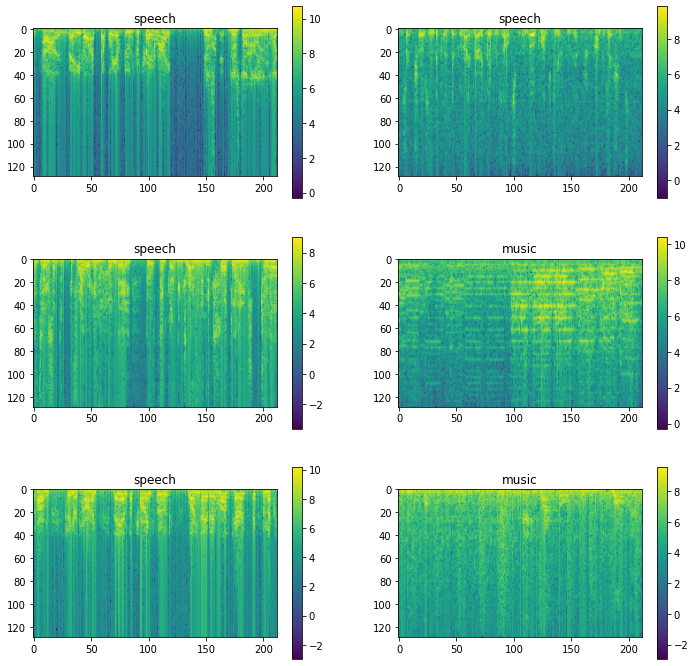

In [40]:
plt.figure(figsize=(12, 12))

st = 0

for i in range(0, 6):
    x, y = x_train[st + i], y_train[st + i]

    plt.subplot(3, 2, i + 1)
    plt.imshow(x, cmap="viridis")
    plt.title(index_to_class[y.numpy()])
    plt.colorbar()
plt.show()

# Task 6: Create the Model

In [41]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense

input_ = Input(shape=(129,212))
x=Lambda(lambda x: tf.expand_dims(x,axis=-1))(input_)
for i in range(4):
  num_filters= 2**(5+i)
  x=Conv2D(num_filters,3)(x)
  x=BatchNormalization()(x)
  x=Activation('tanh')(x)
  x=MaxPool2D(2)(x)

x=Flatten()(x)
x=Dropout(0.4)(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(1,activation='sigmoid')(x)

model=tf.keras.models.Model(input_,x)


In [42]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
    metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda (Lambda)              (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 210, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 210, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 127, 210, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 105, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 103, 64)       18496 

# Task 7: Model Training

In [43]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(CustomCallback, self).__init__(*args, **kwargs)
        self.target_acc = kwargs.get("target_acc") or 0.95
        self.log_epoch = kwargs.get("log_epoch") or 5

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("accuracy")
        val_loss = logs.get("val_loss")
        val_acc = logs.get("val_accuracy")

        if (epoch + 1) % self.log_epoch == 0:
            print(f"Epoch: {epoch:3d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc >= self.target_acc:
            print("Target val accuracy achieved", val_acc)
            model.stop_training = True

In [44]:
_=model.fit(
    x_train,y_train,
    validation_data=(x_valid,y_valid),
    batch_size=12,
    epochs=500,
    verbose=False,
    callbacks=[CustomCallback()]
)

Epoch:   4, Loss: 0.6008, Acc: 0.6688, Val Loss: 0.7800, Val Acc: 0.5667
Epoch:   9, Loss: 0.4718, Acc: 0.7735, Val Loss: 0.4081, Val Acc: 0.8267
Epoch:  14, Loss: 0.4125, Acc: 0.8226, Val Loss: 0.3520, Val Acc: 0.8667
Epoch:  19, Loss: 0.3746, Acc: 0.8440, Val Loss: 0.3145, Val Acc: 0.8767
Epoch:  24, Loss: 0.3259, Acc: 0.8761, Val Loss: 0.2833, Val Acc: 0.8867
Epoch:  29, Loss: 0.2933, Acc: 0.8825, Val Loss: 0.2563, Val Acc: 0.8867
Epoch:  34, Loss: 0.3073, Acc: 0.8739, Val Loss: 0.2355, Val Acc: 0.9000
Epoch:  39, Loss: 0.2046, Acc: 0.9167, Val Loss: 0.2190, Val Acc: 0.9100
Epoch:  44, Loss: 0.1986, Acc: 0.9316, Val Loss: 0.1982, Val Acc: 0.9100
Epoch:  49, Loss: 0.1558, Acc: 0.9444, Val Loss: 0.1830, Val Acc: 0.9167
Epoch:  54, Loss: 0.1767, Acc: 0.9509, Val Loss: 0.1663, Val Acc: 0.9267
Epoch:  59, Loss: 0.1168, Acc: 0.9658, Val Loss: 0.1635, Val Acc: 0.9267
Epoch:  64, Loss: 0.1128, Acc: 0.9701, Val Loss: 0.1506, Val Acc: 0.9267
Epoch:  69, Loss: 0.1228, Acc: 0.9658, Val Loss: 0.

# Task 8: Predictions

In [45]:
example=next(data_iter)
x_test,y_test=preprocess_example(example)
preds=model.predict(x_test)
pred_classes=tf.squeeze(tf.cast(preds>0.5,tf.int8))

In [46]:
pred_classes

<tf.Tensor: shape=(6,), dtype=int8, numpy=array([0, 0, 0, 0, 0, 0], dtype=int8)>

In [47]:
y_test

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0])>